This notebook will be used to develop the reference values that will be measured by the temperature, pressure and flow sensors. The reference values will be transformed on the sensor simulator to emulate its measurements for a normal operation and fault conditions, such as overpressure and high decay rates.

First of all, we need to import the necessary libraries and define the constants that will be used in the simulation.

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [225]:
def generate_reference_data(x, offset = 0.3):
    
    y = np.where(x < 10, 3 * np.exp(-0.1 * x) * np.sin(x),
        np.where(x < 20, 1.5 * np.exp(-0.1 * (x - 10)),
        np.where(x < 30, 0.75 * np.exp(-0.05 * (x - 20)), 0.3 * np.exp(-0.01 * (x - 30)))))
    return y + offset  # Assuming there is a base level flow of 0.3 L/min

def interpolate_with_noise(values, step=0.05, noise_level=0.1):
    interpolated_values = []
    for i in range(len(values) - 1):
        # Unpack the current and next tuple
        (t1, temp1), (t2, temp2) = values[i], values[i + 1]

        # Calculate the number of steps between the two times
        steps = int(round((t2 - t1) / step))

        steps = range(1, steps)

        # Find the temperature difference and set a minimum difference threshold
        temps_diff = max(math.fabs(temp2 - temp1), 0.05)

        # Modify the noise level based on the temperature difference
        # The noise level is higher for smaller differences and lower for larger differences
        adjusted_noise_level = noise_level / (1 + temps_diff)

        # Generate the intermediate values with noise
        for i, s in enumerate(steps, start=1):
            # Calculate the intermediate time
            current_time = t1 + s * step

            # Linear interpolation formula
            current_temp = temp1 + ((temp2 - temp1) / (t2 - t1)) * (current_time - t1)

            denominator = math.exp(-i + 1) + 1.5

            # Introduce noise
            noise = random.uniform(-adjusted_noise_level/denominator, adjusted_noise_level/denominator)
            current_temp_with_noise = current_temp + noise

            # Append the interpolated value to the list
            interpolated_values.append((round(current_time, 2), current_temp_with_noise))

        # Add the last value of the current interval if it's not the last tuple
        if i < len(values) - 2:
            interpolated_values.append((t2, temp2 + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    # Append the last value of the entire sequence with noise
    final_time, final_temp = values[-1]
    interpolated_values.append((final_time, final_temp + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    return interpolated_values



def draw_reference_graph(values = [], step = 0.05, noise_level = 0.1):
    interpolated_values = interpolate_with_noise(values, step, noise_level)
    # Separate the time and temperature values
    times = [time for time, _ in interpolated_values]
    temperatures = [temp for _, temp in interpolated_values]
    
    # Plotting the graph
    plt.plot(times, temperatures, label='Reference Flow', color='blue')
        
    plt.title('Reference vs Bad Process Air Flow')
    plt.xlabel('Time or other variable')  # Replace with the actual independent variable
    plt.ylabel('L/min')
    plt.legend()
    plt.show()

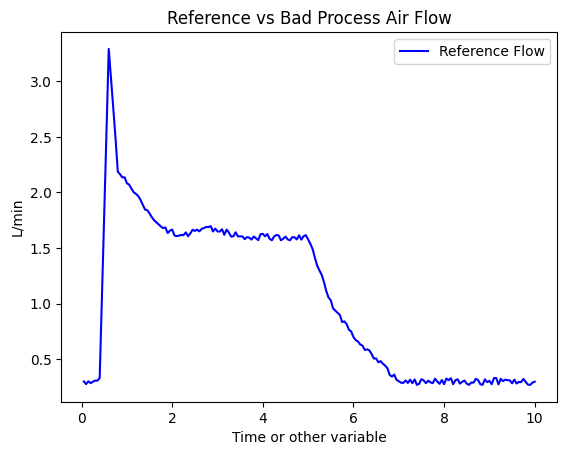

In [226]:
values = [
    (0, 0.3),
    (0.4, 0.3),
    (0.6, 3.3),
    (0.8, 2.2),
    (1.7, 1.7),
    (2.2, 1.6),
    (2.7, 1.7),
    (3.5, 1.6),
    (5, 1.6),
    (5.5, 1),
    (6, 0.7),
    (7, 0.3),
    (10, 0.3)
]
draw_reference_graph(values, step = 0.05, noise_level = 0.05)
